In [30]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import bitarray, time, urllib, ssl
from scipy import signal, integrate
from fractions import gcd

%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [31]:
# function to compute least common multipler
def lcm(numbers):
    return reduce(lambda x, y: (x*y)/gcd(x,y), numbers, 1)

# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = floor(len(x)/N)
    x_ = reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, mean(abs(X)**2,axis=0)


In [155]:
def afsk(bits, fs = 48000, baud=1200, mark_f = 1200, space_f = 2200):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at 44100Hz
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
    fs_lcm = lcm((baud, fs))
    
    fc = (mark_f+space_f)/2
    df = (mark_f-space_f)/2
    
    samples_per_bit = fs_lcm/baud
    mark_f = np.empty(0)
    
    N = samples_per_bit*len(bits)
    
    for i in bits:
        mark_f = np.r_[mark_f, np.repeat(1 if i else -1, samples_per_bit)]
        
    t = np.linspace(0,len(bits)*1.0/baud,N-1)
    
    phase = 2*pi*fc*t + 2*pi*df*integrate.cumtrapz(mark_f*(1.0/fs_lcm))
    sig = np.cos(phase)
    
    return sig[::fs_lcm/fs]

def mfsk(bits, fs = 48000, baud=1200, fc=1600, df=200):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at 48000Hz
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
    seg_to_mark = {
        '00': -3*df,
        '01': -df,
        '10': df,
        '11': 3*df
    }
    
    fs_lcm = lcm((baud, fs))
    
    samples_per_bit = fs_lcm/baud
    mark_f = np.empty(0)
    
    N = samples_per_bit*len(bits)

    segs = np.split(np.array(bits.tolist()), len(bits)/2)
    
    for seg in segs:
        mark_f = np.r_[mark_f, np.repeat(seg_to_mark[reduce(lambda a,b: str(a)+str(b), seg.astype(int).tolist())], samples_per_bit)]
        
    t = np.linspace(0,len(bits)*1.0/baud,N/2-1)
    
    phase = 2*pi*fc*t + 2*pi*df*integrate.cumtrapz(mark_f*(1.0/fs_lcm))
    sig = np.cos(phase)
    
    return sig[::fs_lcm/fs]

def nc_afsk1200Demod(sig, fs=48000.0, baud=1200, TBW=2.0, mark_f=1200, space_f=2200):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    # your code here
    
    h_lp = signal.firwin(N,600.0,nyq=fs/2,window='hanning')
    sig = signal.fftconvolve(sig, h_lp, mode='same')
    
    N = (fs*TBW*1.0/baud // 2) * 2 + 1
    h = signal.firwin(N,600.0,nyq=fs/2,window='hanning') #might want higher, band pass filter at beginning and end

    t = np.arange(0,N*1.0/fs, 1.0/fs)
    
    h_s = np.exp(1j*2*pi*t*mark_f) * h
    h_m = np.exp(1j*2*pi*t*space_f) * h

    space = np.abs(signal.fftconvolve(sig, h_s, mode='same'))
    mark = np.abs(signal.fftconvolve(sig, h_m, mode='same'))

    NRZ = space - mark
    return NRZ

def PLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):
    # 
    # function implements a simple phased lock loop for timing recovery
    #
    # Inputs:
    #          NRZa -   The NRZ signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baude  - the bit rate
    #
    # Outputs:
    #          idx - array of indexes to sample at
    #
    #ctr = int32(-2147483648)
#   idx = zeros(len(NRZa)//int(Ns)*2)
    ctr = int32(0)
    idx = []
    prev_val = NRZa[0]
    cur_val = NRZa[0]
    for i in range(NRZa.shape[0]):
        # increment counter
        prev_ctr = ctr
        ctr = int32(ctr + 2**32/(fs/baud))
        
        #check overflow
        if np.sign(prev_ctr) == 1 and np.sign(ctr) == -1:
            idx += [i]
        
        #zero-crossing
        prev_val, cur_val = cur_val, NRZa[i]
        if np.sign(cur_val) != np.sign(prev_val):
            ctr = int32(ctr * a)
            
    return idx

/Users/shane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


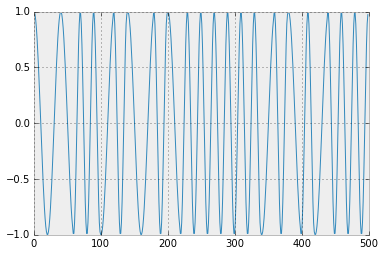

/Users/shane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


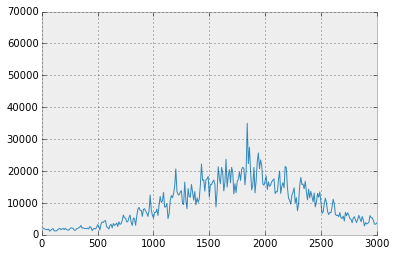

20
4096
0.0380859375


In [156]:
fs = 48e3
baud = 2400
df = 10
mark_f, space_f = 1200, 2400 #mark and space multiplse
L = 4096
sigma = .25

bits=bitarray.bitarray((rand(L)>0.5).tolist())

# Your code here
sig = afsk(bits, fs=fs, baud=baud, mark_f=mark_f, space_f=space_f)
# sig = mfsk(bits, fs=fs)

plt.plot(sig[:500])
plt.show()

sig = sig + sigma*np.random.randn(sig.shape[0])

f, P = avgPS(sig, N=int(fs/df), fs=fs)
plt.plot(f,P)
plt.axis([0,3e3,0,70000])
plt.show()

NRZa = nc_afsk1200Demod(sig, fs, baud, mark_f=mark_f, space_f=space_f)

Ns = int(1.0*fs/baud) 
print Ns

idx = np.r_[Ns/2:NRZa.shape[0]:Ns]
print len(idx)
bit_dec = bitarray.bitarray((NRZa[idx] > 0).tolist())

num_correct = (~(bits ^ bit_dec)).count()
BER = (L-num_correct*1.0)/L
print BER

In [146]:
sigmas = [0, 1, 1.5, 2]
bauds = [1200, 1600, 2400]
#minimum-shift keying
fc = 1800
dfs = [600]
bits = bitarray.bitarray((rand(L)>0.5).tolist())

for s in sigmas:
    for baud in bauds:
        for df in dfs:
            mark_f, space_f = fc-df, fc+df #mark and space multiplse
            sigma = 1

            sig = afsk(bits, fs=fs, baud=baud, mark_f=mark_f, space_f=space_f)

            sig = sig + s*np.random.randn(sig.shape[0])
            NRZa = nc_afsk1200Demod(sig, fs, baud, mark_f=mark_f, space_f=space_f)
            Ns = int(1.0*fs/baud)
            idx = np.r_[Ns/2:NRZa.shape[0]:Ns]
            
            bit_dec = bitarray.bitarray((NRZa[idx] > 0).tolist())

            num_correct = (~(bits ^ bit_dec)).count()
            BER = (L-num_correct*1.0)/L
            print s, baud, df, BER

0 1200 600 0.0
0 1600 600 0.0
0 2400 600 0.0
1 1200 600 0.00333333333333
1 1600 600 0.00666666666667
1 2400 600 0.0633333333333
1.5 1200 600 0.0666666666667
1.5 1600 600 0.0533333333333
1.5 2400 600 0.126666666667
2 1200 600 0.136666666667
2 1600 600 0.13
2 2400 600 0.246666666667


/Users/shane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [92]:
NRZa = nc_afsk1200Demod(sig, fs, baud)
idx = PLL(NRZa, baud=baud)

bit_dec = bitarray.bitarray((NRZa[idx] > 0).tolist())

num_correct = (~(bits ^ bit_dec)).count()
BER = (L-num_correct*1.0)/L

print BER

ValueError: bitarrays of equal length expected for bitwise operation